In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
import math

# Carregando o conjunto de dados

In [2]:
covid = pd.read_csv('covid_pre_proc.csv')
del covid['Unnamed: 0']

In [3]:
covid.head()

,localCaso,sexoCaso,dataNascimento,idadeCaso,racaCor,resultadoFinalExame
0,SOBRAL,MASCULINO,14/08/2003,17.0,Parda,Negativo
1,PACAJUS,MASCULINO,07/11/1983,37.0,Parda,Negativo
2,FORTALEZA,MASCULINO,12/03/1992,28.0,Parda,Negativo
3,CAUCAIA,MASCULINO,06/03/1970,50.0,Sem Informacao,Negativo
4,FORTALEZA,FEMININO,10/01/1939,81.0,Parda,Negativo


# Consultas

**Q1:** Qual o município (atributo *municipioCaso*) com o menor número de casos positivos (atributo *resultadoFinalExame*) de COVID-19;

In [4]:
def Q1(df: pd.DataFrame):
    dict_locais_posit = dict(df['localCaso'][df['resultadoFinalExame'] == 'Positivo'].value_counts())
    
    return min(dict_locais_posit, key=lambda k: dict_locais_posit[k])

**Q2:** Qual a raça (atributo *Raça*) com o maior número de casos negativos de COVID-19;

In [5]:
def Q2(df: pd.DataFrame):
    dict_raca_neg = dict(df['racaCor'][df['resultadoFinalExame'] == 'Negativo'].value_counts())
    
    return max(dict_raca_neg, key=lambda k: dict_raca_neg[k])

# Funções auxiliares

### Funções de utilidade

Usei o log porque a função exponencial dá erro para valores muito altos.

In [6]:
def scores_Q1(df: pd.DataFrame) -> dict:
    return dict(-np.log2(df['localCaso'][df['resultadoFinalExame'] == 'Positivo'].value_counts()))

In [7]:
def scores_Q2(df: pd.DataFrame) -> dict:
    return dict(np.log2(df['racaCor'][df['resultadoFinalExame'] == 'Negativo'].value_counts()))

### Função que calcula a sensibilidade

In [8]:
def delta_u(scores: dict) -> int:
    scores_ = scores.values()
    
    # função de score diminui ou aumenta em um qdo os datasets são vizinhos   
    return 1 #max(scores_) - min(scores_)

# Mecanismo Exponencial

In [9]:
def exponential(budget: float, scores: dict, show_plot=True) -> str:
    probabilities = []
    sensitivity = delta_u(scores)
    
    for i in range(len(scores)):
        probability = math.exp((budget*(list(scores.values())[i])) / (2*sensitivity))
        probabilities.append(probability)
        
    probabilities = [probabilities[j]/sum(probabilities) for j in range(len(probabilities))]
    #print([(k,p) for k, p in zip(list(scores.keys()), probabilities)])
    
    if show_plot:
        plt.plot(probabilities, scaley=False)
        plt.title('Probabilidade de cada chave ser escolhida com eps = {}\n'.format(budget))
        plt.show()
    
    output = random.choices(population=list(scores.keys()), weights=probabilities, k=1)[0]
        
    return output

### Executando o mecanismo para todos os valores de epsilon e para todas as consultas

In [10]:
epsilon = [0.1, 0.5, 1, 10]
queries = [Q1, Q2]


------------------------------ CONSULTA Q1 ------------------------------


------------------------------ EPSILON = 0.1 ------------------------------



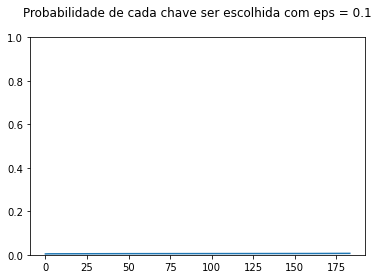

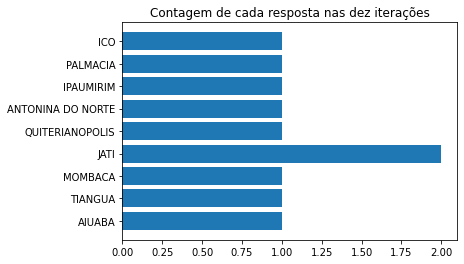



------------------------------ EPSILON = 0.5 ------------------------------



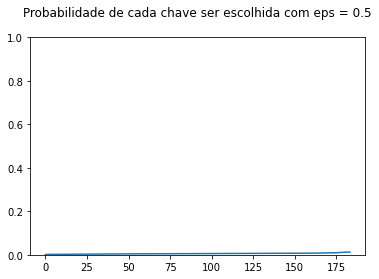

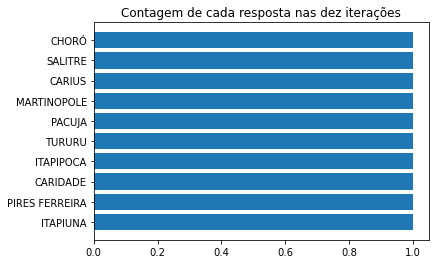



------------------------------ EPSILON = 1 ------------------------------



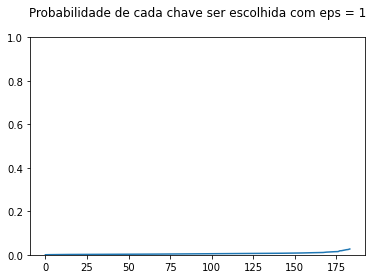

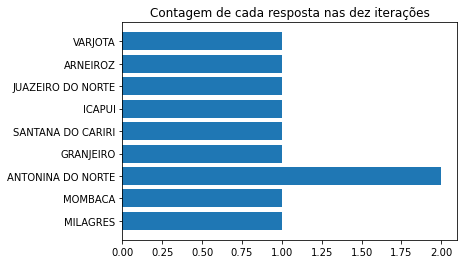



------------------------------ EPSILON = 10 ------------------------------



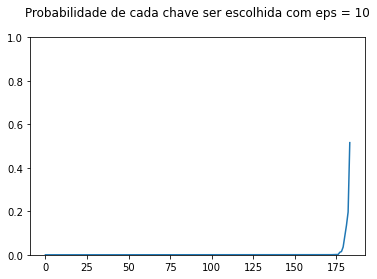

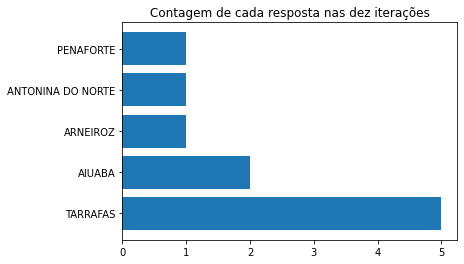


------------------------------ CONSULTA Q2 ------------------------------


------------------------------ EPSILON = 0.1 ------------------------------



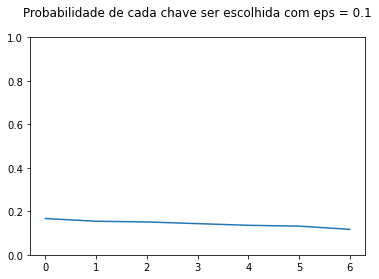

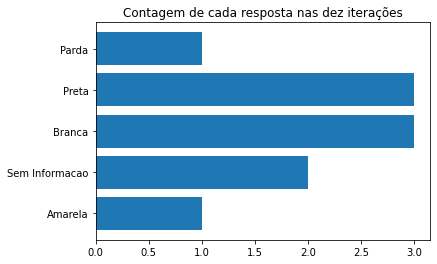



------------------------------ EPSILON = 0.5 ------------------------------



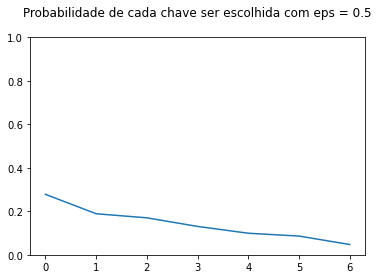

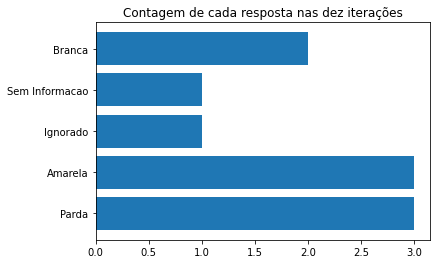



------------------------------ EPSILON = 1 ------------------------------



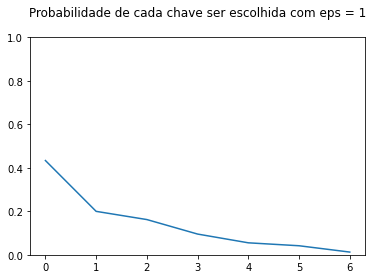

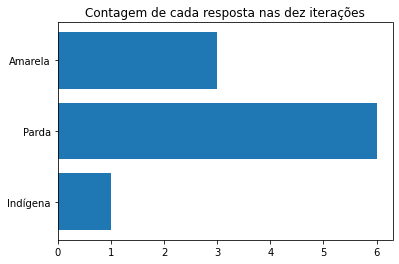



------------------------------ EPSILON = 10 ------------------------------



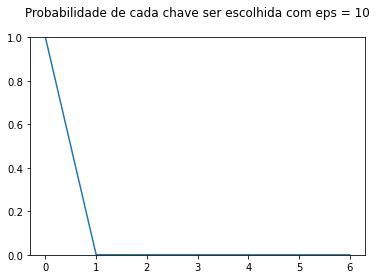

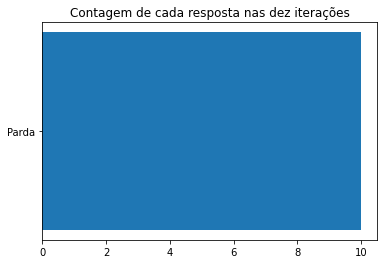

In [11]:
results_queries = []
sep = '-'*30

for q in queries:
    print('\n{} CONSULTA {} {}'.format(sep, q.__name__, sep))
    query_eps = {}
    for eps in epsilon:
        show = True
        query_eps_i = []
        print('\n\n{} EPSILON = {} {}\n'.format(sep, eps,sep))
        for _ in range(10):
            scores_q = locals()['scores_{}'.format(q.__name__)](covid)
            result_i = exponential(eps, scores_q, show_plot=show)
            show = False
            query_eps_i.append(result_i)
        plt.barh(query_eps_i, [query_eps_i.count(i) for i in query_eps_i])
        plt.title('Contagem de cada resposta nas dez iterações')
        plt.show()
        query_eps[eps] = max(set(query_eps_i), key=query_eps_i.count)
    results_queries.append(query_eps)

In [12]:
results_queries[0]['Resposta Original'] = Q1(covid)
results_queries[1]['Resposta Original'] = Q2(covid)

final_result = pd.DataFrame(results_queries, index = ['Consulta 1', 'Consulta 2']).T
final_result.index.name = 'ε'
final_result

,Consulta 1,Consulta 2
ε,,
0.1,JATI,Branca
0.5,CHORÓ,Parda
1,ANTONINA DO NORTE,Parda
10,TARRAFAS,Parda
Resposta Original,TARRAFAS,Parda


# Menu

In [13]:
def menu():    
    def call_exponential(query, eps):
        results = []
        show = True
        for _ in range(10):
            scores = globals()['scores_{}'.format(query.__name__)](covid)
            result_i = exponential(eps, scores, show_plot=show)
            show = False
            results.append(result_i)
        plt.barh(results, [results.count(i) for i in results])
        plt.title('Contagem de cada resposta nas dez iterações')
        plt.show()

        return max(set(results), key=results.count)
    
    def menu_eps(query):
        op_eps = int(input('\nEscolha o valor de budget desejado:\n\n(1) ε = 0.1\n(2) ε = 0.5\n(3) ε = 1\n(4) ε = 10\n\n'))
        if op_eps == 1:
            return call_exponential(query, 0.1)
        elif op_eps == 2:
            return call_exponential(query, 0.5)
        elif op_eps == 3:
            return call_exponential(query, 1)
        elif op_eps == 4:
            return call_exponential(query, 10)
        else:
            print('Escolha uma das opções válidas.')
            return menu_eps(query)
        
    sep = '-'*30
    print('{} MENU {}\n\n'.format(sep, sep))
    op = int(input('Escolha uma operação:\n\n(1) Consulta Q1: município com menor número de casos positivos.\n(2) Consulta Q2: raça com maior número de casos negativos.\n(3) Mecanismo exponencial sobre a consulta Q1.\n(4) Mecanismo exponencial sobre a consulta Q2.\n\n'))

    if op == 1:
        return Q1(covid)
    elif op == 2:
        return Q2(covid)
    elif op == 3:
        return menu_eps(Q1)
    elif op == 4:
        return menu_eps(Q2)
    elif op == 5:
        return
    else:
        print('Escolha uma das opções válidas.')
        return menu()

------------------------------ MENU ------------------------------


Escolha uma operação:

(1) Consulta Q1: município com menor número de casos positivos.
(2) Consulta Q2: raça com maior número de casos negativos.
(3) Mecanismo exponencial sobre a consulta Q1.
(4) Mecanismo exponencial sobre a consulta Q2.

3

Escolha o valor de budget desejado:

(1) ε = 0.1
(2) ε = 0.5
(3) ε = 1
(4) ε = 10

3


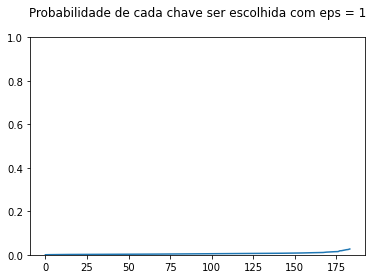

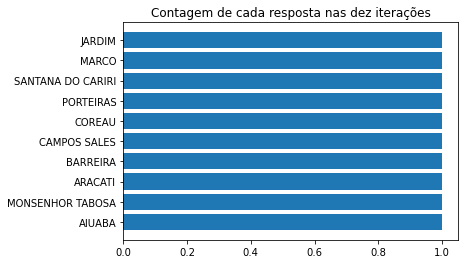

'PORTEIRAS'

In [14]:
menu()